In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer # fazer a transformação de colunas
from sklearn.dummy import DummyRegressor # regressor padrão para comparação
from sklearn.linear_model import ElasticNet, LinearRegression # modelo de regressão
from sklearn.pipeline import Pipeline # criar pipeline, etapa de processamento
from sklearn.preprocessing import (
    OrdinalEncoder, # variáveis ordinais
    OneHotEncoder, # categóricas
    PolynomialFeatures, # criar variáveis com multiplicação entre ela ou ao quadrado dela mesma 
    PowerTransformer, # transformação em potência (yeo-johnson ou box-cox)
    RobustScaler, 
    StandardScaler, # ajuste de escala das variáveis independentes
    QuantileTransformer, # normaliza os dados em quantis
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
# separando todas as colunas numéricas para realizar uma transformação uniforme
# ele não é tão sensível a outliers
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

Criando uma etapa de Polynomial Feature em cima das colunas numéricas após essas colunas passarem por um ajuste de escala passando pelo RobustScaler. Primeiro, é necessário criar um Pipeline separada, definir as etapas (steps=), a primeira delas é a transformação de escala e em seguida aplicada as PolynomialFeatures, Por último incluímos a pipeline dentro do pré-processamento.

In [7]:
# o grau inicial da segunda etapa é 1, mas ele será alterado
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # primeira etapa da pipeline
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # segunda etapa da pipeline 
])

# pré-processamento pegando a pipeline com a transformação de escala e PolynomialFeatures
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler) # usando a pipeline transformada
    ],
)

In [8]:
# separando X e y da base de dados
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [11]:
# acessando o regressor, depois em preprocessor, em seguida acessando a transformação robust_scaler_poly, 
# entrando na etapa de PolynomialFeatures e verificando qual o melhor grau entre 1,2 e 3
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
}

In [12]:
# criando uma pesquisa de grade buscando a melhor combinação entre 
# pré-processamento e transformação apresenta o melhor resultado 
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), # o modelo
    preprocessor=preprocessamento, # pré-processamento
    target_transformer=QuantileTransformer(output_distribution="normal"), # transformação no target
    param_grid=param_grid, # procurando o grau de liberdade com melhor desempenho
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
# treinando o grid_search
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\barbo\anaconda3\envs\aprendizado_maquina\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

        O treinamento do modelo foi rápido, considerando o número de validações que foram reduzidos, agora apenas 3 candidatos tendo a validação cruzada por 5, resultando em 15 treinamentos diferentes, o melhor desempenho.

In [15]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

        O grau de PolynomialFeature com melhor desempenho foi o grau 3.

In [17]:
# métrica RMSE (Root Mean Square Error - raiz do erro quadrático médio)
# é a métrica de desempate no refit de validação cruzada da função grid_search_cv_regressor
grid_search.best_score_

np.float64(-51139.30928803121)

        O modelo com PolynomialFeatures apresentou um RMSE com o desempenho um pouco melhor que o modelo anterior.

In [19]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler_poly__longitude total_rooms,-316648.239738
robust_scaler_poly__housing_median_age total_rooms,-229736.119738
robust_scaler_poly__latitude total_rooms,-218778.623229
robust_scaler_poly__rooms_per_household total_bedrooms,-216755.915145
robust_scaler_poly__latitude population_per_household total_rooms,-209436.223569
...,...
robust_scaler_poly__households,168146.021702
robust_scaler_poly__longitude population,171564.413431
robust_scaler_poly__latitude population rooms_per_household,210796.542524
robust_scaler_poly__bedrooms_per_room households,221116.091038


        Após passar pelas combinações de grau 3 das PolynomialFeatures, os coeficientes foram multiplicados, passando de 11 features numéricas para 364, somando com a target e duas categóricas fica no total de 367 coeficientes.

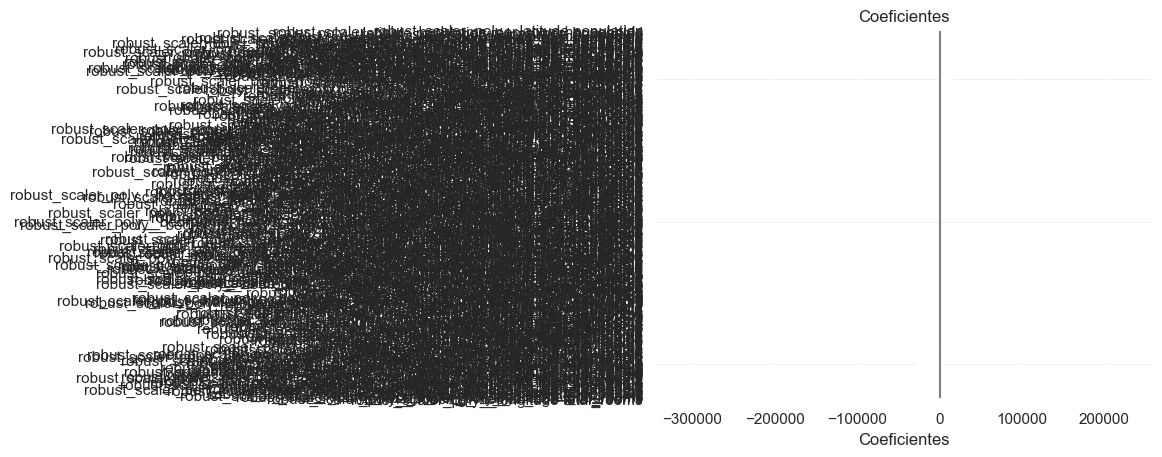

In [21]:
# criando um gráfico com os coeficientes
plot_coeficientes(coefs)

        Conforme foram criados uma quantidade massiva de coeficientes comparados com a quantidade de features iniciais, é impossível gerar um gráfico com os coeficientes, pois existe sobreposição que dificulta na interpretação e explicação dos resultados.

Verificando as possibilidade de avaliar os múltiplos coeficientes de PolynomialFeatures

In [24]:
# verificando se existem coeficientes nulos
coefs[coefs["coeficiente"] == 0]

,coeficiente


        Dentre 367 coeficientes, nenhum deles é iguais a zero, sendo assim, todas as features parecem ter alguma importância para o resultado do target. Após isso, pode ser interessante usar regularização para identificar as features que não têm tanta relevância para o resultado do target.

In [26]:
# verificando os coeficientes dentro de uma determinada faixa para eliminar coeficientes muito pequenos
# como a faixa dos valores entre os coeficientes é de -300.000 até 200.000
# verificando os coeficientes entre -100.000 e 100.000
coefs[coefs["coeficiente"].between(-100_000, 100_000)]

,coeficiente
robust_scaler_poly__households housing_median_age population_per_household,-93123.184818
robust_scaler_poly__population_per_household total_bedrooms,-87525.045880
robust_scaler_poly__latitude population_per_household,-83062.759143
robust_scaler_poly__households^2 population_per_household,-65493.424642
robust_scaler_poly__bedrooms_per_room median_income,-64806.822079
...,...
robust_scaler_poly__housing_median_age total_bedrooms,71095.597470
robust_scaler_poly__bedrooms_per_room rooms_per_household total_rooms,76275.083026
robust_scaler_poly__latitude rooms_per_household,79412.618264
robust_scaler_poly__rooms_per_household^2,81354.319000


        Identificamos 343 coeficientes dentro dessa faixa, o que significa que apenas 24 coeficientes estão fora da faixa de -100.000 e 100.000.

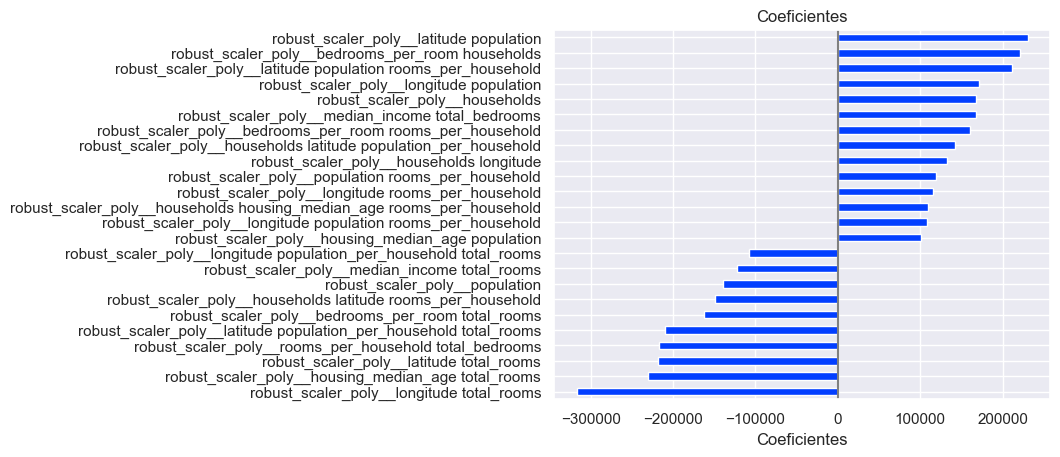

In [53]:
# criando um gráfico com os coeficientes fora da faixa estabelecida acima
# lembrando que a faixa total entre os coeficientes varia entre -300.000 e 200.000
# usando o operador negativo para pegar todos os coeficientes exceto os dentro da faixa estabelecida 
plot_coeficientes(coefs[~coefs["coeficiente"].between(-100_000, 100_000)])

        É possível notar a difernça entre os coeficientes, agora tempos várias combinações de colunas, a ordem de importância delas foi alterada, com o cruzamento das variáveis latitude x population tendo o maior coeficiente positivo, entre outras alterações visíveis no ordenamento e combinação das colunas.
        Conforme a limitação do resultados dos coeficientes, as PolynomialFeatures podem ser um problema, já que nosso modelo teve uma melhora significativa, mas a interpretação do modelo ficou bem mais complexa, com isso é necessário fazer um balanceamento para saber se a complexidade do modelo compensa o trabalho realizado.        

In [67]:
# comparando os processamentos entre os modelos
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
   
    "LinearRegression_target":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
   
    "LinearRegression_grid_search":{
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002999,0.002507,-0.000081,-77516.042766,-96239.705692,0.005506
1,DummyRegressor,0.002001,0.002001,-0.000146,-75787.787194,-95217.629397,0.004002
2,DummyRegressor,0.002,0.002002,-0.001737,-76753.598961,-96253.253947,0.004003
3,DummyRegressor,0.002518,0.002002,-0.000101,-76837.804811,-95983.885799,0.00452
4,DummyRegressor,0.001998,0.003,-0.000114,-76617.245449,-96182.764729,0.004999
5,LinearRegression,0.016583,0.00752,0.682162,-39855.690996,-54254.958188,0.024103
6,LinearRegression,0.019012,0.007008,0.66999,-40272.565467,-54695.230283,0.02602
7,LinearRegression,0.020027,0.006003,0.649247,-42178.05929,-56955.988706,0.02603
8,LinearRegression,0.018018,0.005505,0.669873,-40806.492497,-55146.318803,0.023523
9,LinearRegression,0.016508,0.00651,0.669023,-40788.496497,-55331.35106,0.023017


In [73]:
# agrupando por modelo e apresentando a média de cada variável, ordenando pelo RMSE
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002303,0.002303,-0.000436,-76702.495836,-95975.447913,0.004606
LinearRegression,0.01803,0.006509,0.668059,-40780.26095,-55276.769408,0.024539
LinearRegression_target,0.024519,0.007206,0.678043,-38673.46905,-54435.116843,0.031725
LinearRegression_grid_search,0.176483,0.014819,0.715916,-35576.287139,-51130.693086,0.191302


        Com base na média das métricas dos modelos, é possível notar a melhora do modelo grid_search comparado aos demais, porém o tempo de treinamento é consideravelmente maior.

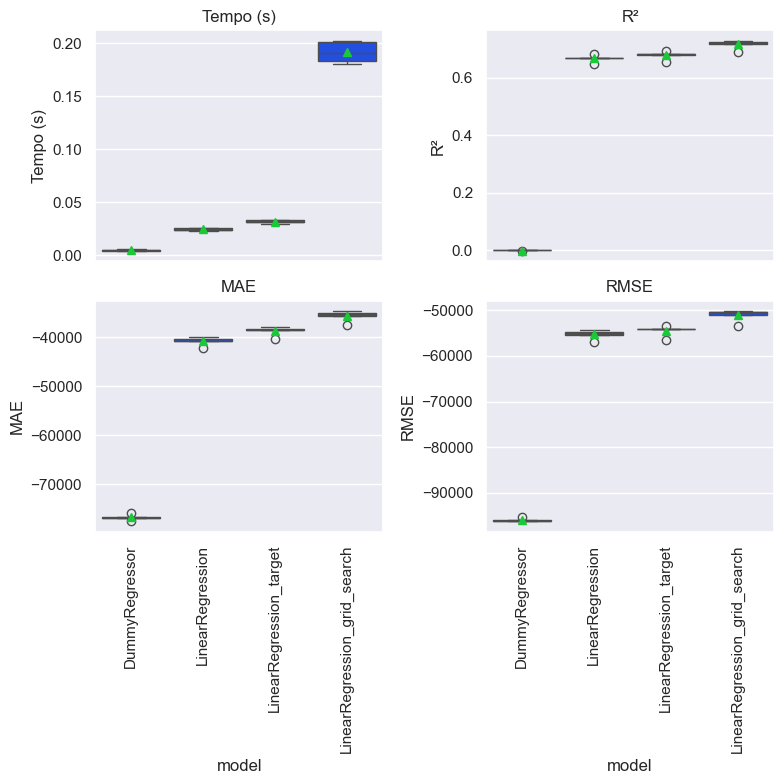

In [75]:
# criando um gráfico com a comparação dos modelos
plot_comparar_metricas_modelos(df_resultados)

plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        Analisando os boxplots para comparação entre os modelos, é possível ver que o resultado das métricas parecem uma escada, com o grid_search trazendo métricas melhores que os demais modelos, porém o tempo de treinamento é bem elevado, em torno de 4 vezes mais demorado que o modelo apenas com transformação de target (terceiro modelo).

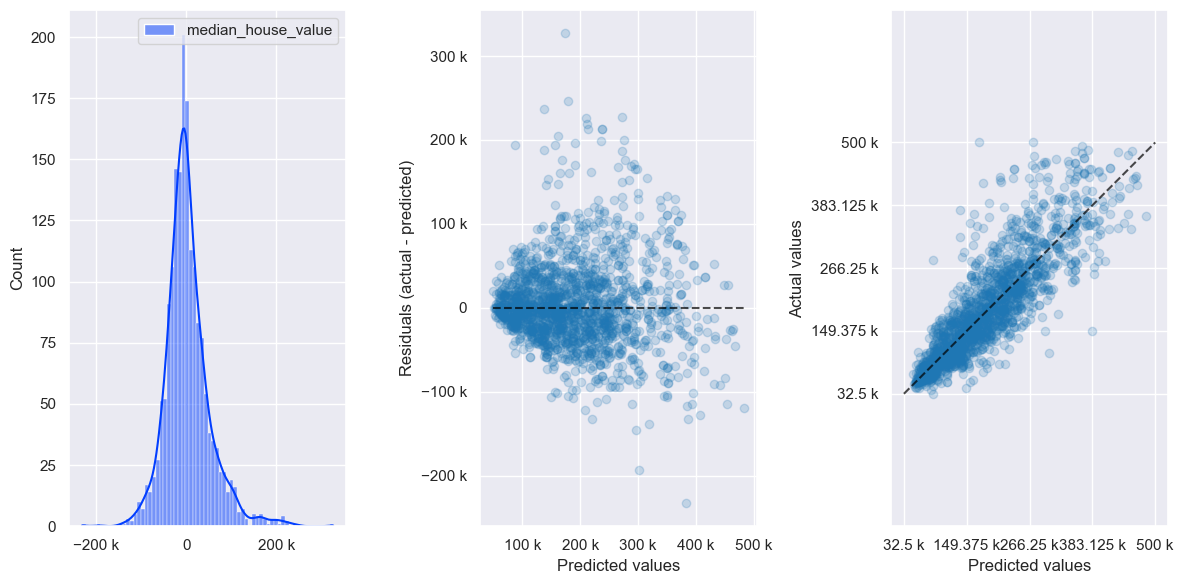

In [79]:
# verificando os resíduos
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        Nosso modelo continua errando para menos, com valores até 300.000, mesmo assim a maior concentração de pontos está próximo de zero, mas, aparentemente, o modelo começou a errar menos já que a concentração de pontos altos parece ter diminuído.